 <font size="6">  Image data inspection </font> 

---

In this notebook, we look at the intensity distribution and find optimized parameters for normalization.

## Load library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import seaborn as sns
import glob
import pandas as pd
from davinci.vectra_tool import *
import imageio
from PIL.TiffTags import TAGS
import tifffile

## Load file

In [2]:
tiff_images = sorted(glob.glob('../data/tif/*.tif') )
sample_ids = (np.array([x.split('/')[-1].split(' ')[0] for i,x in enumerate(tiff_images)]))
sample_id,count = np.unique(np.array([x.split('/')[-1].split(' ')[0] for i,x in enumerate(tiff_images)]), return_counts=True)

## Load marker information

In [3]:
marker_list = ['chan1', 'chan2', 'chan3', 'chan4', 'chan5', 'chan6', 'chan7']   # for real data: [x.description.split('<Name>')[1].split(' ')[0].split('<')[0].split('+')[0] for x in  tifffile.TiffFile(tiff_images[0]).pages[:7] ]
print(marker_list)

['chan1', 'chan2', 'chan3', 'chan4', 'chan5', 'chan6', 'chan7']


## Get the max intensity of one channel from each image

### Get the locally smoothed max value from each image

In [4]:
%%time
max_array_blur = np.array([np.max([ndimage.gaussian_filter(x,sigma=3) for x in tifffile.imread(x)[:7]],axis=(1,2)) for i,x in enumerate(tiff_images)  ])

CPU times: user 404 ms, sys: 53.2 ms, total: 457 ms
Wall time: 456 ms


### Get the raw max value from each sample

### Get the locally smoothed max value from each sample

In [5]:
sample_blur_max_list = []
one_sample = []

start = 0
for x in count:
    sample_blur_max_list.append(np.max(max_array_blur[start:start+x],axis=(0)))
    start+=x
    
sample_blur_max_list = np.array(sample_blur_max_list)

## Visualization

### Display the distribution of the max value of each image

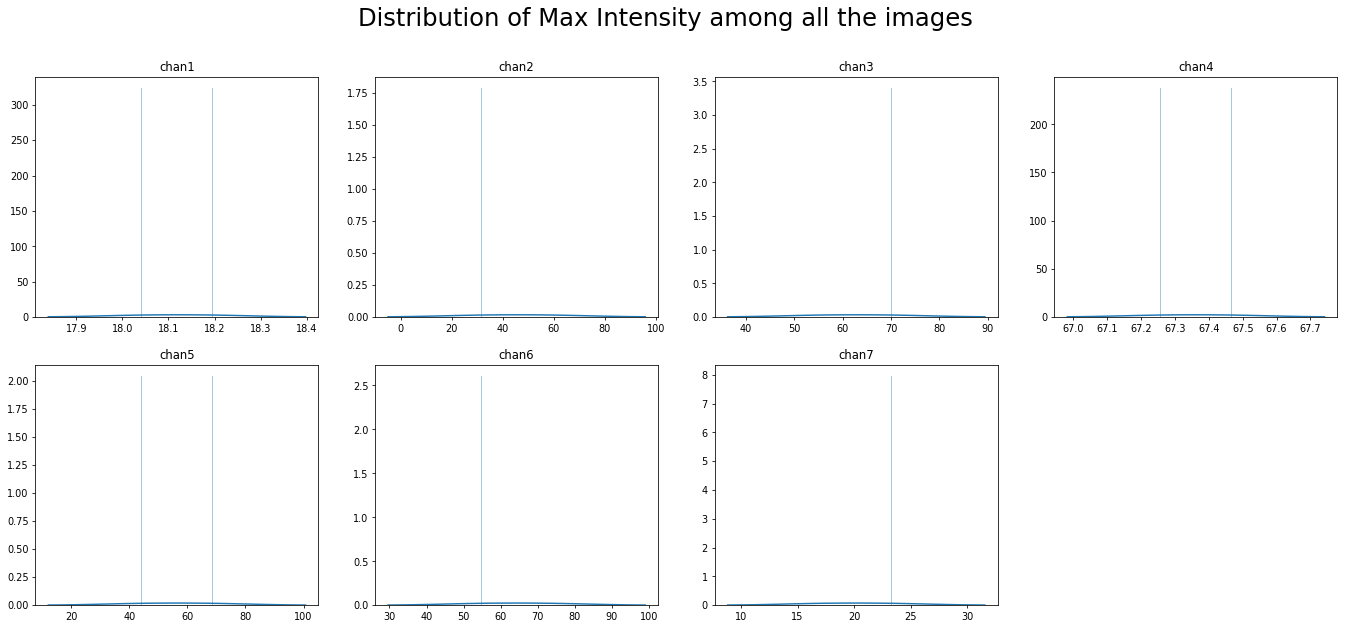

In [6]:
plot_max_tiff_img_dis(max_array_blur,bins=100,channel_name=marker_list)

### Display the distribution of the Max value of each sample 

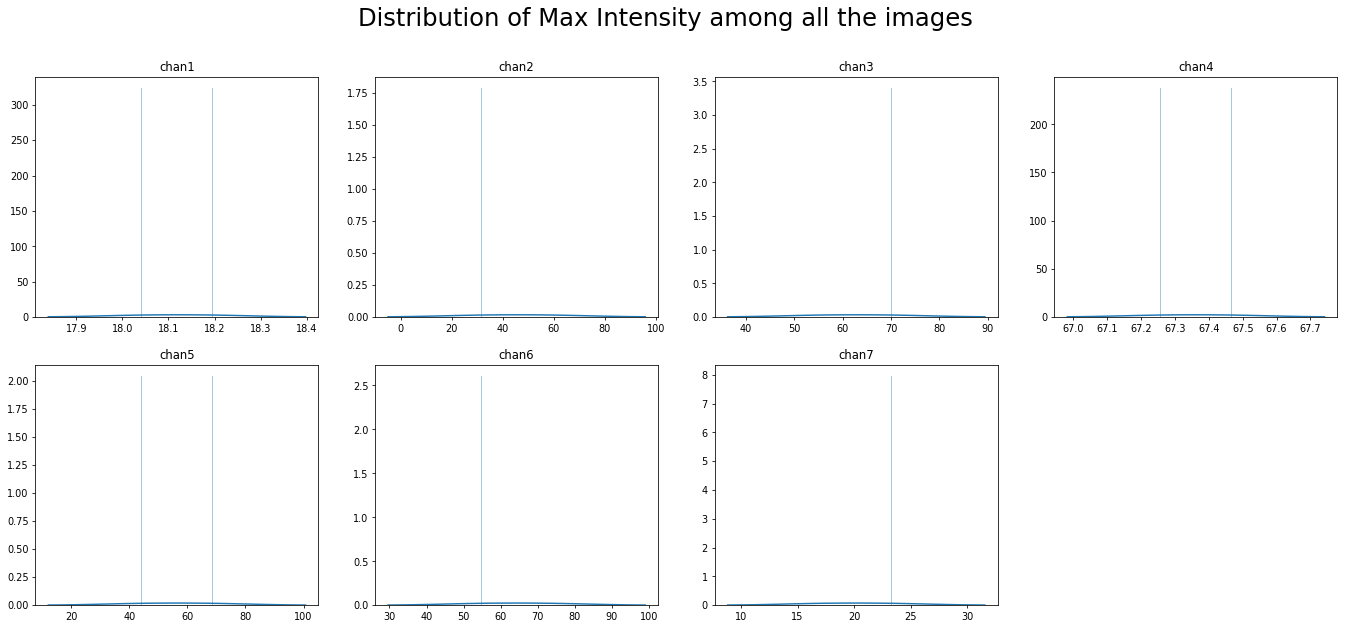

In [7]:
plot_max_tiff_img_dis(sample_blur_max_list,bins=100,channel_name=marker_list)

## Visualization of images with and without max normalization

In this figure, the images from the first two columns are sample with smallest max intensity of one marker, while the images from the last two columns are from sample with largest max intensity. The 1st, 3rd columns are raw image while the 2nd, 4th are the norm by the max value in a range of 25 to its smoothed sample max value. 

The value 25 is based on our observation on our data. It can be adjusted according to your dataset.

We display the results channel by channel. And in each sample, we display 4 rows (4 images from each sample).

In [8]:
min_max = 25

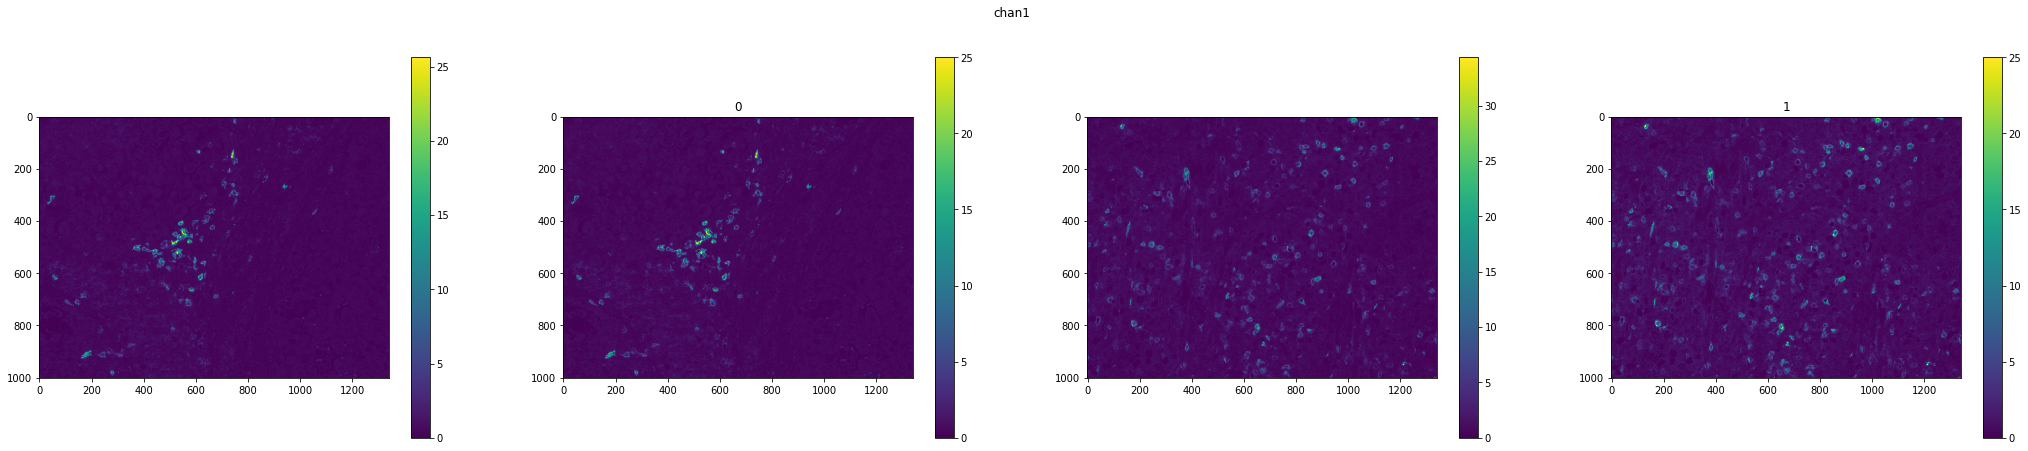

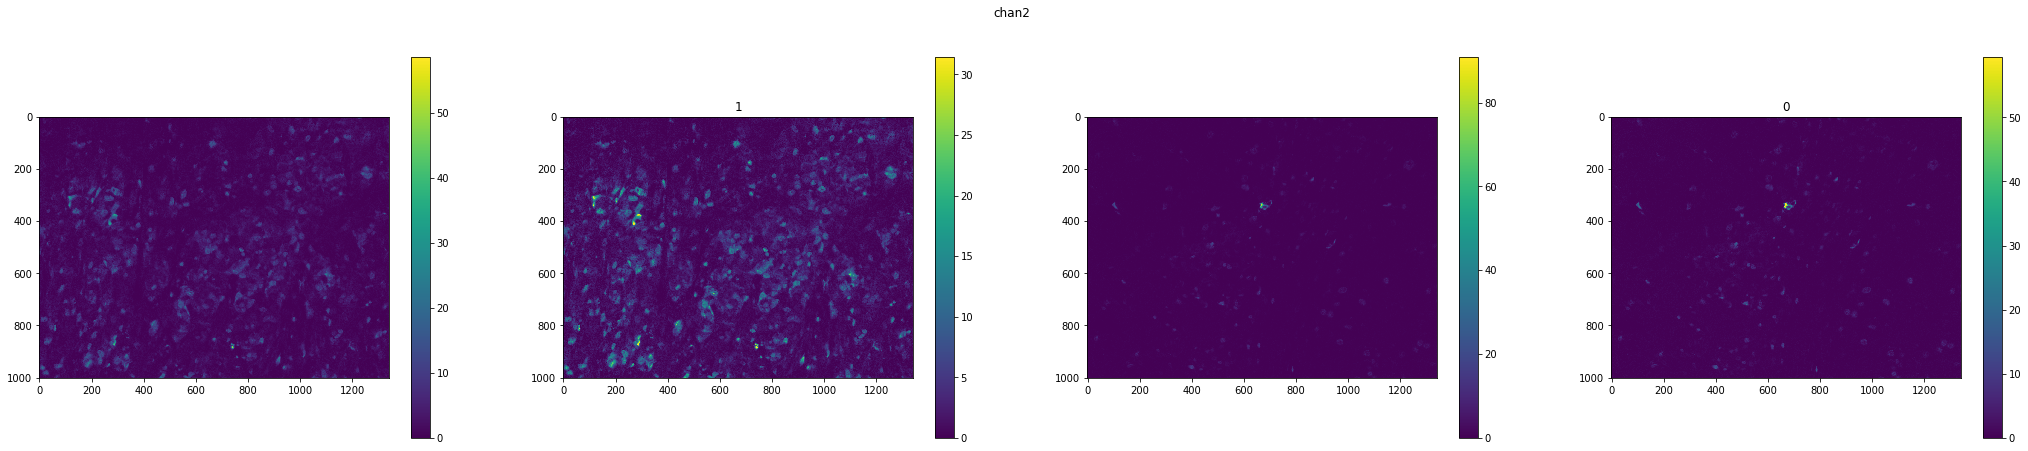

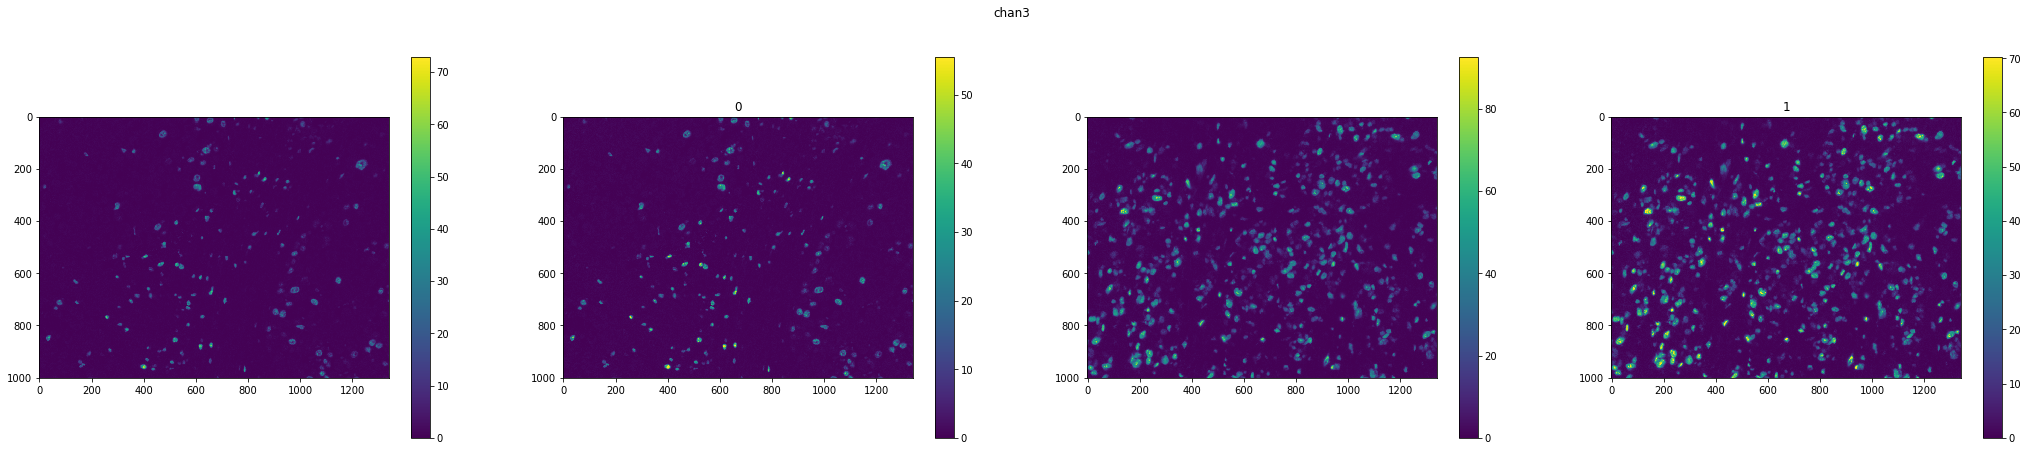

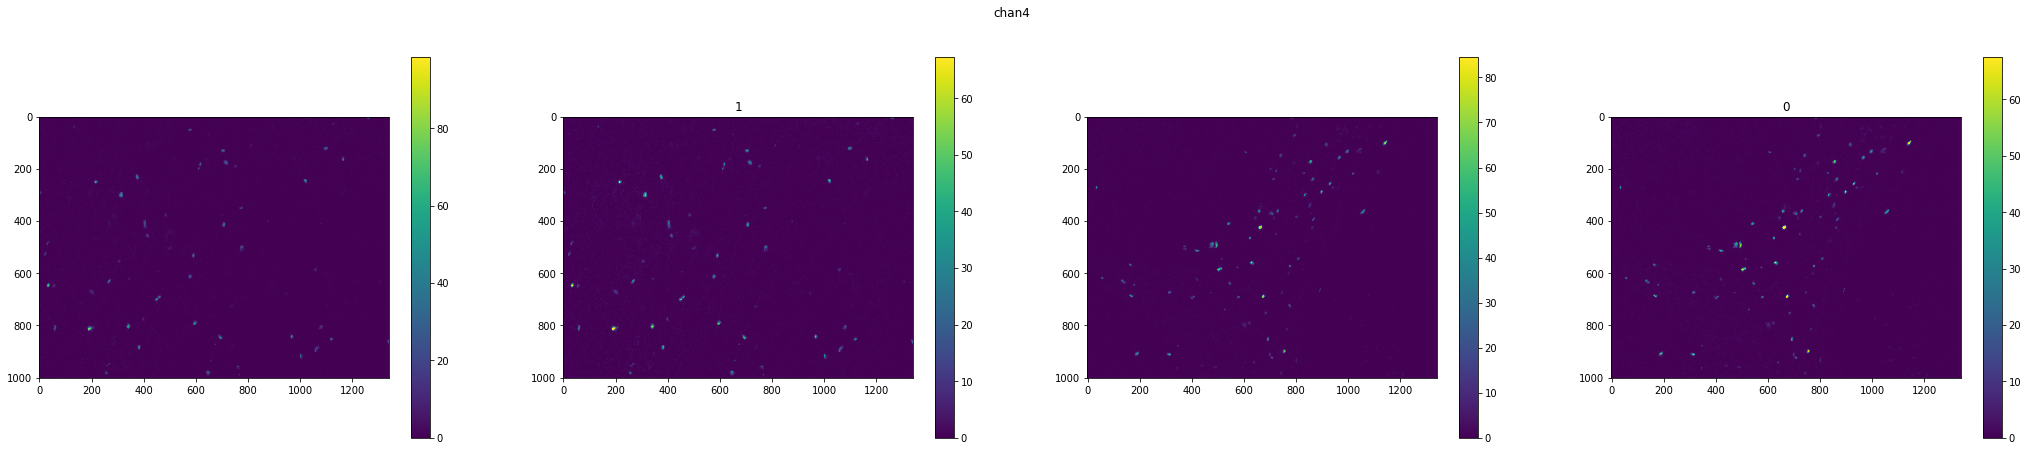

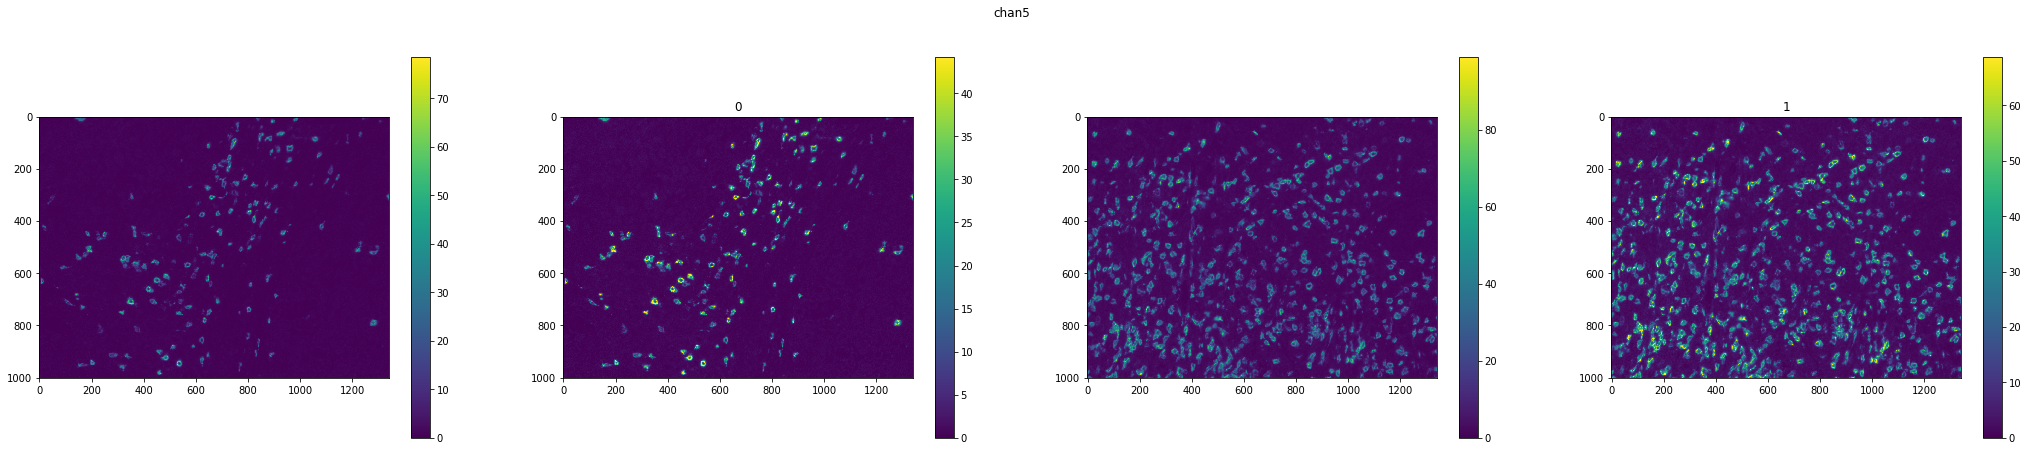

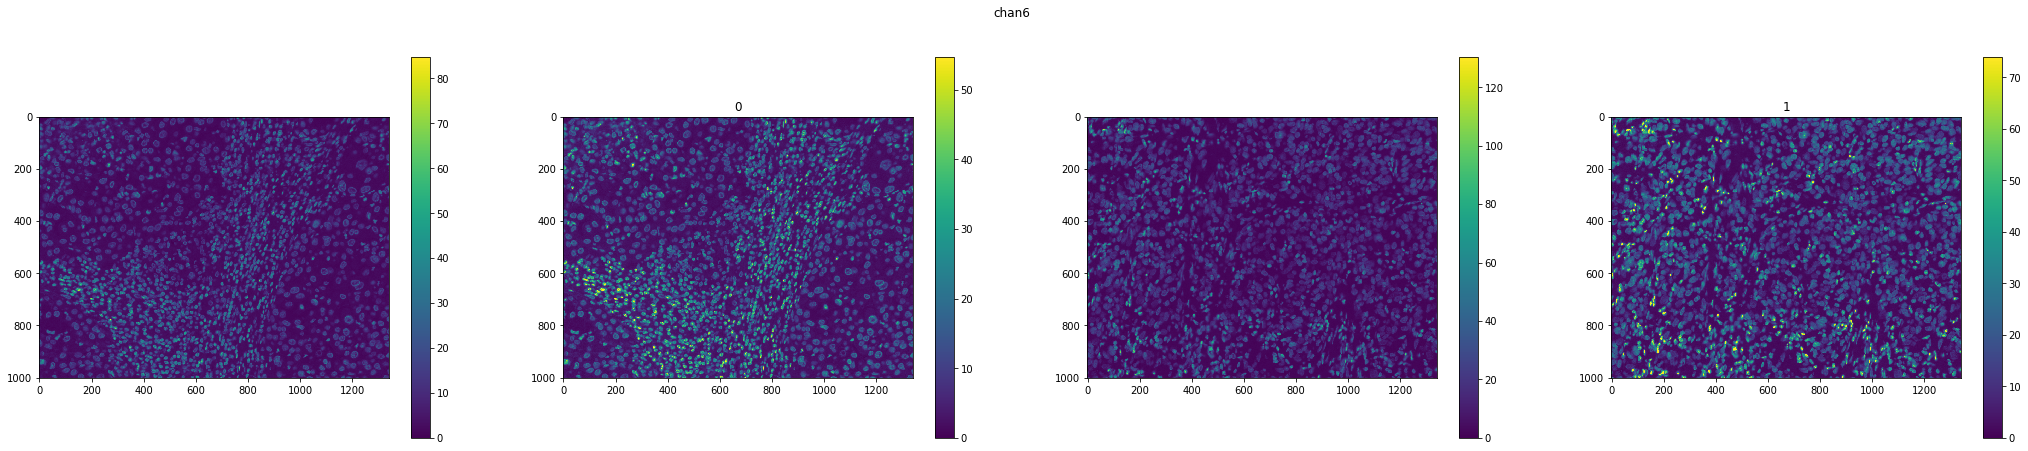

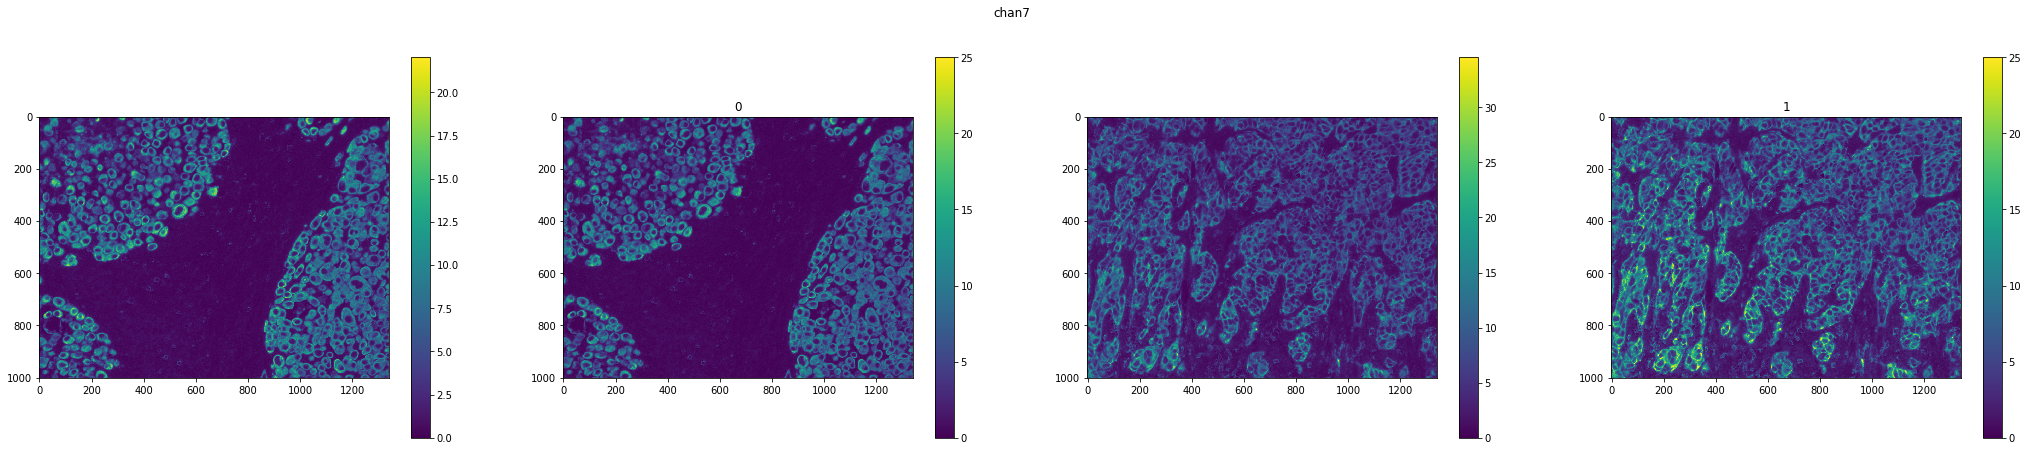

In [9]:
for i in range(len(marker_list)):
    num=min(4,min(count))
    ranking = np.argsort(max_array_blur[:,i])
    sample1 = ranking[0]
    sample2 = ranking[-1]
    image1s = np.random.choice(np.where(sample_ids == sample_id[sample1])[0],num,replace=True)
    image2s = np.random.choice(np.where(sample_ids == sample_id[sample2])[0],num,replace=True)
    plt.figure(figsize=(36,7*num))
    for j in range(num):
        plt.subplot(num,4,j*4+1)
        img1 = tifffile.imread(tiff_images[image1s[j]])[i]
        plt.imshow(img1)
        plt.colorbar()
        plt.subplot(num,4,j*4+2)
        plt.title(image1s[j])
        img1 = tifffile.imread(tiff_images[image1s[j]])[i]
        plt.imshow(img1)
        max1 = np.clip(np.max(img1),a_min=min_max,a_max=max_array_blur[image1s[j]])
        plt.colorbar()
        plt.clim(0,max1[i])
        plt.subplot(num,4,j*4+3)
        img1 = tifffile.imread(tiff_images[image2s[j]])[i]
        plt.imshow(img1)
        plt.colorbar()
        plt.subplot(num,4,j*4+4)
        plt.title(image2s[j])
        img2 = tifffile.imread(tiff_images[image2s[j]])[i]
        plt.imshow(img2)
        max2 = np.clip(np.max(img2),a_min=min_max,a_max=max_array_blur[image2s[j]])
        plt.colorbar()
        plt.clim(0,max2[i])
        plt.suptitle(marker_list[i])
    #break

### Record the sample level smoothed max intensity

In [10]:
sample_max= sample_blur_max_list.clip(min=min_max)

In [11]:
sample_max = pd.DataFrame(np.array(sample_max))
print(sample_id)
sample_max.index = sample_id
sample_max.to_csv('../parameter/max_cap.csv')

['Sample1' 'Sample2']
